# Previsão de séries temporais financeiras com memória de longo prazo
## https://humboldt-wi.github.io/blog/research/information_systems_1718/06financialtime-series/

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# We read in the dataset
data = pd.read_csv("final_df_VW.csv")
 # delete column you dont want to use for training here!
                      # We are deleteting date here.
data.head()
#print(data)

,googLVL,volLVL,dif_highlowLVL,googRET,daxRET,y_closeRET
0,91.0,94720.0,2.199996,-0.010929,0.014875,0.031513
1,87.0,97289.0,2.200005,-0.044951,-0.008962,-0.005031
2,84.0,68027.0,3.300003,-0.035091,-0.002549,0.023562
3,86.0,61603.0,3.449997,0.023530,-0.006265,-0.009901
4,92.0,82983.0,2.699996,0.067441,-0.006739,-0.008174


In [2]:
# function to normalize
def normalize(df):
    """
        Uses minMax scaler on data to normalize. Important especially for Volume and google_lvl
        @param df: data frame with all features
    """
    df = pd.DataFrame(df)
    df.dropna(inplace = True)
    df = df.values
    df = df.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    norm = scaler.fit_transform(df)
    return scaler, norm

In [3]:
# Append with timesteps
def createTimeSteps(df, lags=1):
    """
        creates the amount of timesteps from the target and appends to df.
        How many lags do we use to predict the target.
        @param df: data frame with all features
        @param lags: number of lags from the target that are appended
    """
    df = pd.DataFrame(df)
    columns = list()
    for i in range(lags, 0, -1):
        columns.append(df.shift(i))
    columns.append(df) #add original
    # combine
    output = pd.concat(columns, axis=1)
    # replace rows with NaN values
    output.fillna(0, inplace = True)
    return output

In [4]:
# Everything prepared...
scaler, normalized_data = normalize(data)

BATCH_SIZE = 1 # batch size during training
TS = 14 # length of Sequence we use for our samples (7 = week, 30 = month)
FEATURES = 6 # number of features in data set
TRAINING_DAYS = 1250 # Training/Test split for data

full_df = createTimeSteps(normalized_data, TS)
# display(full_df)
full_df = full_df.values # Training vs Test

train = full_df[:TRAINING_DAYS, :]
test = full_df[TRAINING_DAYS:, :]

input_var = int(TS*FEATURES) # Every feature has as many columns as defined timestep
target = -1 # Our Volkswagen AG stock price is the last column of our dataset
X_train, y_train = train[:, :input_var], train[:, target]
X_test, y_test = test[:, :input_var], test[:, target]

X_train = X_train.reshape(TRAINING_DAYS, TS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TS, FEATURES)

In [5]:
# Our first very easy model
def helloModel(timesteps, features, batch_size=1):
    model = Sequential()
    model.add(LSTM(16, input_shape=(timesteps, features)))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])  
    return model

In [8]:
# Fit the model
def fitting(model, X, y, val_X, val_y, epochs, batch_size=1, state_config=False, sf=False):
    """
        fits the model to the data via keras API.
        @param model: before designed model setup
        @param X: correctly reshaped input data
        @param y: correctly reshaped target
        @param val_X, val_y: correctly reshaped test data
        @param epochs: number of epochs to repeat training
        @param batch_size: number of rows after the weights of the network are updated
        @param state_config: True/False - if true, model is trained with stateful mode and
        states are resetted every epoch
        @param sf: True/False - shuffle mode. If stateless, this makes sense to increase
        generalization of the model
    """
    if state_config:
        training_mse = list()
        val_mse = list()
        for i in range(epochs):
            model.reset_states()
            result = model.fit(X, y, batch_size=batch_size, epochs=1, validation_data=(val_X, val_y), shuffle=sf)
            training_mse.append(result.history['mse'])
            val_mse.append(result.history['val_mse'])
    else:
        result = model.fit(X, y, batch_size=batch_size,
                        epochs=epochs, validation_data=(val_X, val_y), shuffle=sf)
        training_mse = result.history['mse']
        val_mse = result.history['val_mse']


    return result, training_mse, val_mse

Epoch 1/30
1250/1250 [==============================] - 7s 4ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 2/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 3/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 4/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/30
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 8/30
1250/1250 [==============================] - 4s 3ms

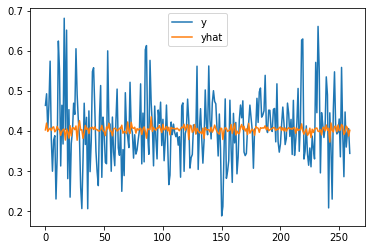

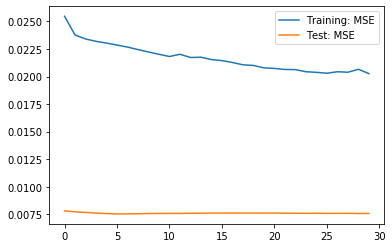

In [10]:
# Almost forgot... your libraries
import keras
from keras import Sequential
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed, RepeatVector
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from pandas import read_csv, DataFrame
import pandas as pd

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os

# Our new CONSTANTS
EPOCHS = 30 # number of training Epochs
STATEFUL = True # stateless/stateful
SF = False # activate shuffle
RETURN_SEQ = False # many to many prediction (outputs results of every TS)

# Choose a model
model =  helloModel(TS, FEATURES, batch_size=BATCH_SIZE)
# Fit the model
result, training_mse, val_mse = fitting(model, X_train, y_train, X_test, y_test, EPOCHS, batch_size=BATCH_SIZE)
# Predict the model
yhat = model.predict(X_test, batch_size = BATCH_SIZE)
print(yhat.shape)
print(y_test.shape)

# Plot the model
plt.plot(y_test, label='y')
plt.plot(yhat, label='yhat')
plt.legend()
plt.show()

plt.plot(training_mse, label='Training: MSE')
plt.plot(val_mse, label='Test: MSE')
plt.legend()
plt.show()